# AutoEncoder MNIST example

Note: This notebook is designed to run with CPU (no GPU) runtime.

Import modules and set random seeds.

In [1]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

random.seed(20230515)
np.random.seed(20190222)
tf.random.set_seed(20190222)

plt.rcParams.update({'font.size': 10})

Download the MNIST dataset and store into NumPy arrays.

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

Define the AutoEncoder model for MNIST images.

In [3]:
model = models.Sequential(name='AutoEncoder')
model.add(layers.Input(shape=(784,), name='input'))
model.add(layers.Dense(256, activation='relu', name='feedforward1'))
model.add(layers.Dense(128, activation='relu', name='feedforward2'))
model.add(layers.Dense(16, activation='relu', name='feedforward3'))
model.add(layers.Dense(128, activation='relu', name='feedforward4'))
model.add(layers.Dense(256, activation='relu', name='feedforward5'))
model.add(layers.Dense(784, activation='sigmoid', name='output'))

model.summary()

Model: "AutoEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feedforward1 (Dense)                 │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward2 (Dense)                 │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward3 (Dense)                 │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward4 (Dense)                 │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward5 (Dense)                 │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 784)                 │         201,488 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 472,608 (1.80 MB)

 Trainable params: 472,608 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the Adam optimizer, and MSE as a loss function.

In [4]:
model.compile(optimizer='adam', loss='mse')

Define a function to show reconstructed images.

In [5]:
labels = [np.argmax(label) for label in test_labels]
sample_images = np.array([test_images[labels.index(i)] for i in range(10)])

def show_result():
    results = model.predict(sample_images, verbose=0)

    fig = plt.figure(figsize=(10, 2))
    for i in range(10):
      subplot = fig.add_subplot(2, 10, i+1)
      subplot.set_xticks([])
      subplot.set_yticks([])
      subplot.imshow(sample_images[i].reshape((28, 28)),
                     vmin=0, vmax=1, cmap=plt.cm.gray_r)

      subplot = fig.add_subplot(2, 10, i+11)
      subplot.set_xticks([])
      subplot.set_yticks([])
      subplot.imshow(results[i].reshape((28, 28)),
                     vmin=0, vmax=1, cmap=plt.cm.gray_r)

Train the model for a single epoch with 30,000 images, and show the intermediate result.

235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0885


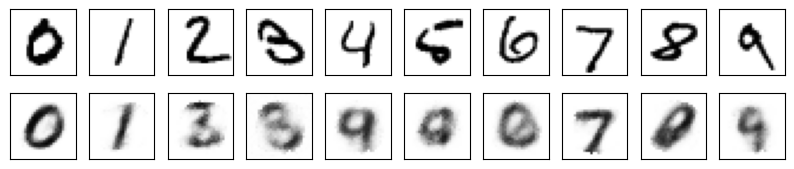

In [6]:
history = model.fit(train_images[:30000], train_images[:30000],
                    batch_size=128, epochs=1)
show_result()

Train the model for additional epochs, and show the final result.

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0313
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.0231
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0207
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0194
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0184
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0177
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0171
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0166
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0161
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0157


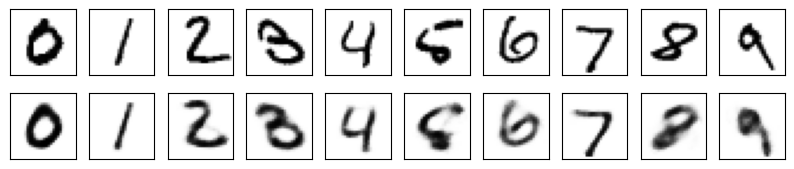

In [7]:
history = model.fit(train_images, train_images,
                    batch_size=128, epochs=10)
show_result()

Define a Javascript function to create a drawing canvas.

In [8]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e) {
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0, 0, 0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY*0.2);
            y = Math.floor(e.offsetX*0.2) + 1;
            for (var dy = 0; dy < 2; dy++) {
                for (var dx = 0; dx < 2; dx++) {
                    if ((x + dx < 28) && (y + dy < 28)) {
                        pixels[(y+dy)+(x+dx)*28] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });

    function set_value() {
        var result = "";
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
        google.colab.kernel.invokeFunction(
                          'notebook.set_image', [result], {});
    }

    function clear_value() {
        canvas.getContext("2d").fillStyle = "rgb(255, 255, 255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    }
</script>
"""

Show a drawing canvas.

In [11]:
from google.colab import output
from IPython.display import HTML

def set_image(result):
    global image
    image = np.array([float(x) for x in result.split(',')[:-1]])

image = None
output.register_callback('notebook.set_image', set_image)

HTML(input_form + javascript)

Show a resconstructed image from the handwritten example.

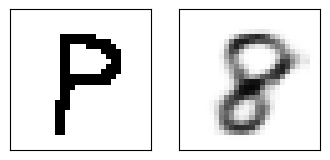

In [17]:
results = model.predict(np.array([image]), verbose=0)

fig = plt.figure(figsize=(4, 2))
subplot = fig.add_subplot(1, 2, 1)
subplot.set_xticks([])
subplot.set_yticks([])
_ = subplot.imshow(np.array(image).reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)
subplot = fig.add_subplot(1, 2, 2)
subplot.set_xticks([])
subplot.set_yticks([])
_ = subplot.imshow(results[0].reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)